In [1]:
import xarray as xr
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client
import numpy as np                                                                                        
import zarr

c = Client()


/home/alberta/anaconda2/envs/pangeo-cloud/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
c

Client Scheduler: tcp://127.0.0.1:35679 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.66 GB


In [3]:
import sys, glob
import numpy as np
import xarray as xr
import xscale.spectral.fft as xfft
import xscale 
import Wavenum_freq_spec_func as wfs
import time

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
from matplotlib.colors import LogNorm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic


In [5]:
zarru='/mnt/alberta/equipes/IGE/meom/workdir/albert/NATL60/NATL60-CJM165-S/1h/SSU/zarr/NATL60-CJM165-SSU-1h-1m2deg2deg'
zarrv='/mnt/alberta/equipes/IGE/meom/workdir/albert/NATL60/NATL60-CJM165-S/1h/SSV/zarr/NATL60-CJM165-SSV-1h-1m2deg2deg'
dsu=xr.open_zarr(zarru)
dsv=xr.open_zarr(zarrv)


In [6]:
%%time
lat=dsu['nav_lat']
lon=dsu['nav_lon']
 
latmin = 40.0; latmax = 45.0;
lonmin = -40.0; lonmax = -35.0;

domain = (lonmin<lon) * (lon<lonmax) * (latmin<lat) * (lat<latmax)
where = np.where(domain)

#get indice
jmin = np.min(where[0][:])
jmax = np.max(where[0][:])
imin = np.min(where[1][:])
imax = np.max(where[1][:])

latbox=lat[jmin:jmax,imin:imax]
lonbox=lon[jmin:jmax,imin:imax]


CPU times: user 2.15 s, sys: 276 ms, total: 2.42 s
Wall time: 7.63 s


In [7]:
%%time

print('Select dates')
u_JFM=dsu.sel(time_counter=slice('2013-01-01','2013-03-31'))['vozocrtx']
v_JFM=dsv.sel(time_counter=slice('2013-01-01','2013-03-31'))['vomecrty']

print('Select box area')
u_JFM_box=u_JFM[:,jmin:jmax,imin:imax]
v_JFM_box=v_JFM[:,jmin:jmax,imin:imax]


# - get dx and dy
print('get dx and dy')
dx_JFM,dy_JFM = wfs.get_dx_dy(u_JFM_box[0],lonbox,latbox)


#... Detrend data in all dimension ...
print('Detrend data in all dimension')
u_JFM = wfs.detrendn(u_JFM_box,axes=[0,1,2])
v_JFM = wfs.detrendn(v_JFM_box,axes=[0,1,2])

#... Apply hanning windowing ...') 
print('Apply hanning windowing')
u_JFM = wfs.apply_window(u_JFM, u_JFM.dims, window_type='hanning')
v_JFM = wfs.apply_window(v_JFM, v_JFM.dims, window_type='hanning')


#... Apply hanning windowing ...') 
print('FFT ')
u_JFMhat = xfft.fft(u_JFM, dim=('time_counter', 'x', 'y'), dx={'x': dx_JFM, 'y': dx_JFM}, sym=True)
v_JFMhat = xfft.fft(v_JFM, dim=('time_counter', 'x', 'y'), dx={'x': dx_JFM, 'y': dx_JFM}, sym=True)

#... Apply hanning windowing ...') 
print('PSD ')
u_JFM_psd = xfft.psd(u_JFMhat)
v_JFM_psd = xfft.psd(v_JFMhat)


#... Get frequency and wavenumber ... 
print('Get frequency and wavenumber')
frequency_JFM = u_JFMhat.f_time_counter
kx_JFM = u_JFMhat.f_x
ky_JFM = u_JFMhat.f_y

#... Get istropic wavenumber ... 
print('Get istropic wavenumber')
wavenumber_JFM,kradial_JFM = wfs.get_wavnum_kradial(kx_JFM,ky_JFM)

#... Get numpy array ... 
print('Get numpy array')
u_JFM_psd_np = u_JFM_psd.values
v_JFM_psd_np = v_JFM_psd.values

#... Get 2D frequency-wavenumber field ... 
print('Get f k in 2D')
u_JFM_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JFM,wavenumber_JFM,u_JFM_psd_np)
v_JFM_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JFM,wavenumber_JFM,v_JFM_psd_np)

KE_JFM_wavenum_freq_spectrum=0.5*(u_JFM_wavenum_freq_spectrum+v_JFM_wavenum_freq_spectrum)


Select dates
Select box area
get dx and dy
Detrend data in all dimension
Apply hanning windowing
FFT 
PSD 
Get frequency and wavenumber
Get istropic wavenumber
Get numpy array


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 27920 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 27918 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 27919 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Get f k in 2D
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
CPU times: user 15min 33s, sys: 1min 8s, total: 16min 42s
Wall time: 21min 35s


In [8]:
# Save to Netscdf file
# - build dataarray
print('Save to Netscdf file')
KE_JFM_wavenum_freq_spectrum_da = xr.DataArray(KE_JFM_wavenum_freq_spectrum,dims=['frequency','wavenumber'],name="Ke_spectrum",coords=[frequency_JFM ,wavenumber_JFM])
KE_JFM_wavenum_freq_spectrum_da.attrs['Name'] = 'KE_Spectrum_JFM_w_k_from_1h_NATL60-CJM165.nc'

KE_JFM_wavenum_freq_spectrum_da.to_dataset().to_netcdf(path='/mnt/alberta/equipes/IGE/meom/workdir/albert/NATL60/NATL60-CJM165-S/1h/KE_Spectrum_JFM_w_k_from_1h_NATL60-CJM165.nc',mode='w',engine='scipy')


Save to Netscdf file


In [7]:
%%time

print('Select dates')
u_JAS=dsu.sel(time_counter=slice('2013-07-01','2013-09-30'))['vozocrtx']
v_JAS=dsv.sel(time_counter=slice('2013-07-01','2013-09-30'))['vomecrty']

print('Select box area')
u_JAS_box=u_JAS[:,jmin:jmax,imin:imax]
v_JAS_box=v_JAS[:,jmin:jmax,imin:imax]


Select dates
Select box area
CPU times: user 156 ms, sys: 32 ms, total: 188 ms
Wall time: 184 ms


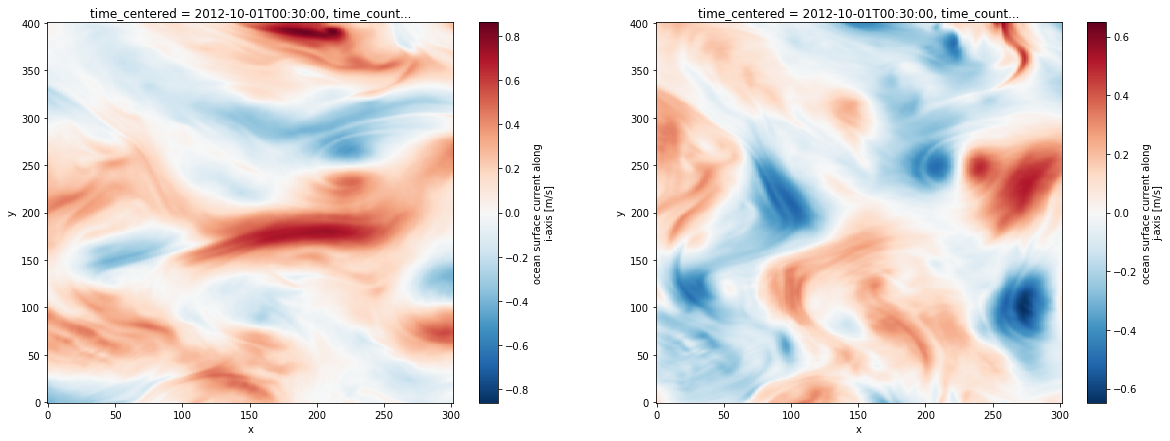

In [12]:
fig=plt.figure(figsize=(20,7))
ax=plt.subplot(121)
u_JAS_box[0].plot()
ax=plt.subplot(122)
v_JAS_box[0].plot()


In [18]:
# - get dx and dy
print('get dx and dy')
dx_JAS,dy_JAS = wfs.get_dx_dy(u_JAS_box[0],lonbox,latbox)


#... Detrend data in all dimension ...
print('Detrend data in all dimension')
u_JAS = wfs.detrendn(u_JAS_box,axes=[0,1,2])
v_JAS = wfs.detrendn(v_JAS_box,axes=[0,1,2])


get dx and dy
Detrend data in all dimension


In [ ]:
fig=plt.figure(figsize=(20,7))
ax=plt.subplot(121)
u_JAS[0].plot()
ax=plt.subplot(122)
v_JAS[0].plot()


In [26]:
print(u_JAS[10].values)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [39]:
da=v_JAS_box
axes=[0,1,2]
    
N = [da.shape[n] for n in axes]
M = []
for n in range(da.ndim):
    if n not in axes:
        M.append(da.shape[n])
d_obs = np.reshape(da.copy().values, (N[0]*N[1]*N[2],1))
G = np.ones((N[0]*N[1]*N[2],4))
G.shape

(267393216, 4)

In [8]:
da=u_JAS_box
axes=[0,1,2]
    
N = [da.shape[n] for n in axes]
M = []
for n in range(da.ndim):
    if n not in axes:
        M.append(da.shape[n])
d_obs = np.reshape(da.copy().values, (N[0]*N[1]*N[2],1))
G = np.ones((N[0]*N[1]*N[2],4))
G[:,3] = np.tile(np.arange(1,N[2]+1), N[0]*N[1])

In [37]:
d_obs.shape

(267393216, 1)

In [7]:
%%time

print('Select dates')
u_JAS=dsu.sel(time_counter=slice('2013-07-01','2013-09-30'))['vozocrtx']
v_JAS=dsv.sel(time_counter=slice('2013-07-01','2013-09-30'))['vomecrty']

print('Select box area')
u_JAS_box=u_JAS[:,jmin:jmax,imin:imax]
v_JAS_box=v_JAS[:,jmin:jmax,imin:imax]


# - get dx and dy
print('get dx and dy')
dx_JAS,dy_JAS = wfs.get_dx_dy(u_JAS_box[0],lonbox,latbox)


#... Detrend data in all dimension ...
print('Detrend data in all dimension')
u_JAS = wfs.detrendn(u_JAS_box,axes=[0,1,2])
v_JAS = wfs.detrendn(v_JAS_box,axes=[0,1,2])

#... Apply hanning windowing ...') 
print('Apply hanning windowing')
u_JAS = wfs.apply_window(u_JAS, u_JAS.dims, window_type='hanning')
v_JAS = wfs.apply_window(v_JAS, v_JAS.dims, window_type='hanning')


#... Apply hanning windowing ...') 
print('FFT ')
u_JAShat = xfft.fft(u_JAS, dim=('time_counter', 'x', 'y'), dx={'x': dx_JAS, 'y': dx_JAS}, sym=True)
v_JAShat = xfft.fft(v_JAS, dim=('time_counter', 'x', 'y'), dx={'x': dx_JAS, 'y': dx_JAS}, sym=True)

#... Apply hanning windowing ...') 
print('PSD ')
u_JAS_psd = xfft.psd(u_JAShat)
v_JAS_psd = xfft.psd(v_JAShat)


#... Get frequency and wavenumber ... 
print('Get frequency and wavenumber')
frequency_JAS = u_JAShat.f_time_counter
kx_JAS = u_JAShat.f_x
ky_JAS = u_JAShat.f_y

#... Get istropic wavenumber ... 
print('Get istropic wavenumber')
wavenumber_JAS,kradial_JAS = wfs.get_wavnum_kradial(kx_JAS,ky_JAS)

#... Get numpy array ... 
print('Get numpy array')
u_JAS_psd_np = u_JAS_psd.values
v_JAS_psd_np = v_JAS_psd.values

#... Get 2D frequency-wavenumber field ... 
print('Get f k in 2D')
u_JAS_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JAS,wavenumber_JAS,u_JAS_psd_np)
v_JAS_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JAS,wavenumber_JAS,v_JAS_psd_np)

KE_JAS_wavenum_freq_spectrum=0.5*(u_JAS_wavenum_freq_spectrum+v_JAS_wavenum_freq_spectrum)


Select dates
Select box area
get dx and dy
Detrend data in all dimension
Apply hanning windowing
FFT 
PSD 
Get frequency and wavenumber
Get istropic wavenumber
Get numpy array


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Get f k in 2D
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
CPU times: user 16min 58s, sys: 1min 13s, total: 18min 11s
Wall time: 27min 49s


In [8]:
# Save to Netscdf file
# - build dataarray
print('Save to Netscdf file')
KE_JAS_wavenum_freq_spectrum_da = xr.DataArray(KE_JAS_wavenum_freq_spectrum,dims=['frequency','wavenumber'],name="Ke_spectrum",coords=[frequency_JAS ,wavenumber_JAS])
KE_JAS_wavenum_freq_spectrum_da.attrs['Name'] = 'KE_Spectrum_JAS_w_k_from_1h_NATL60-CJM165.nc'

KE_JAS_wavenum_freq_spectrum_da.to_dataset().to_netcdf(path='/mnt/alberta/equipes/IGE/meom/workdir/albert/NATL60/NATL60-CJM165-S/1h/KE_Spectrum_JAS_w_k_from_1h_NATL60-CJM165.nc',mode='w',engine='scipy')


Save to Netscdf file


/home/alberta/anaconda2/envs/pangeo-cloud/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


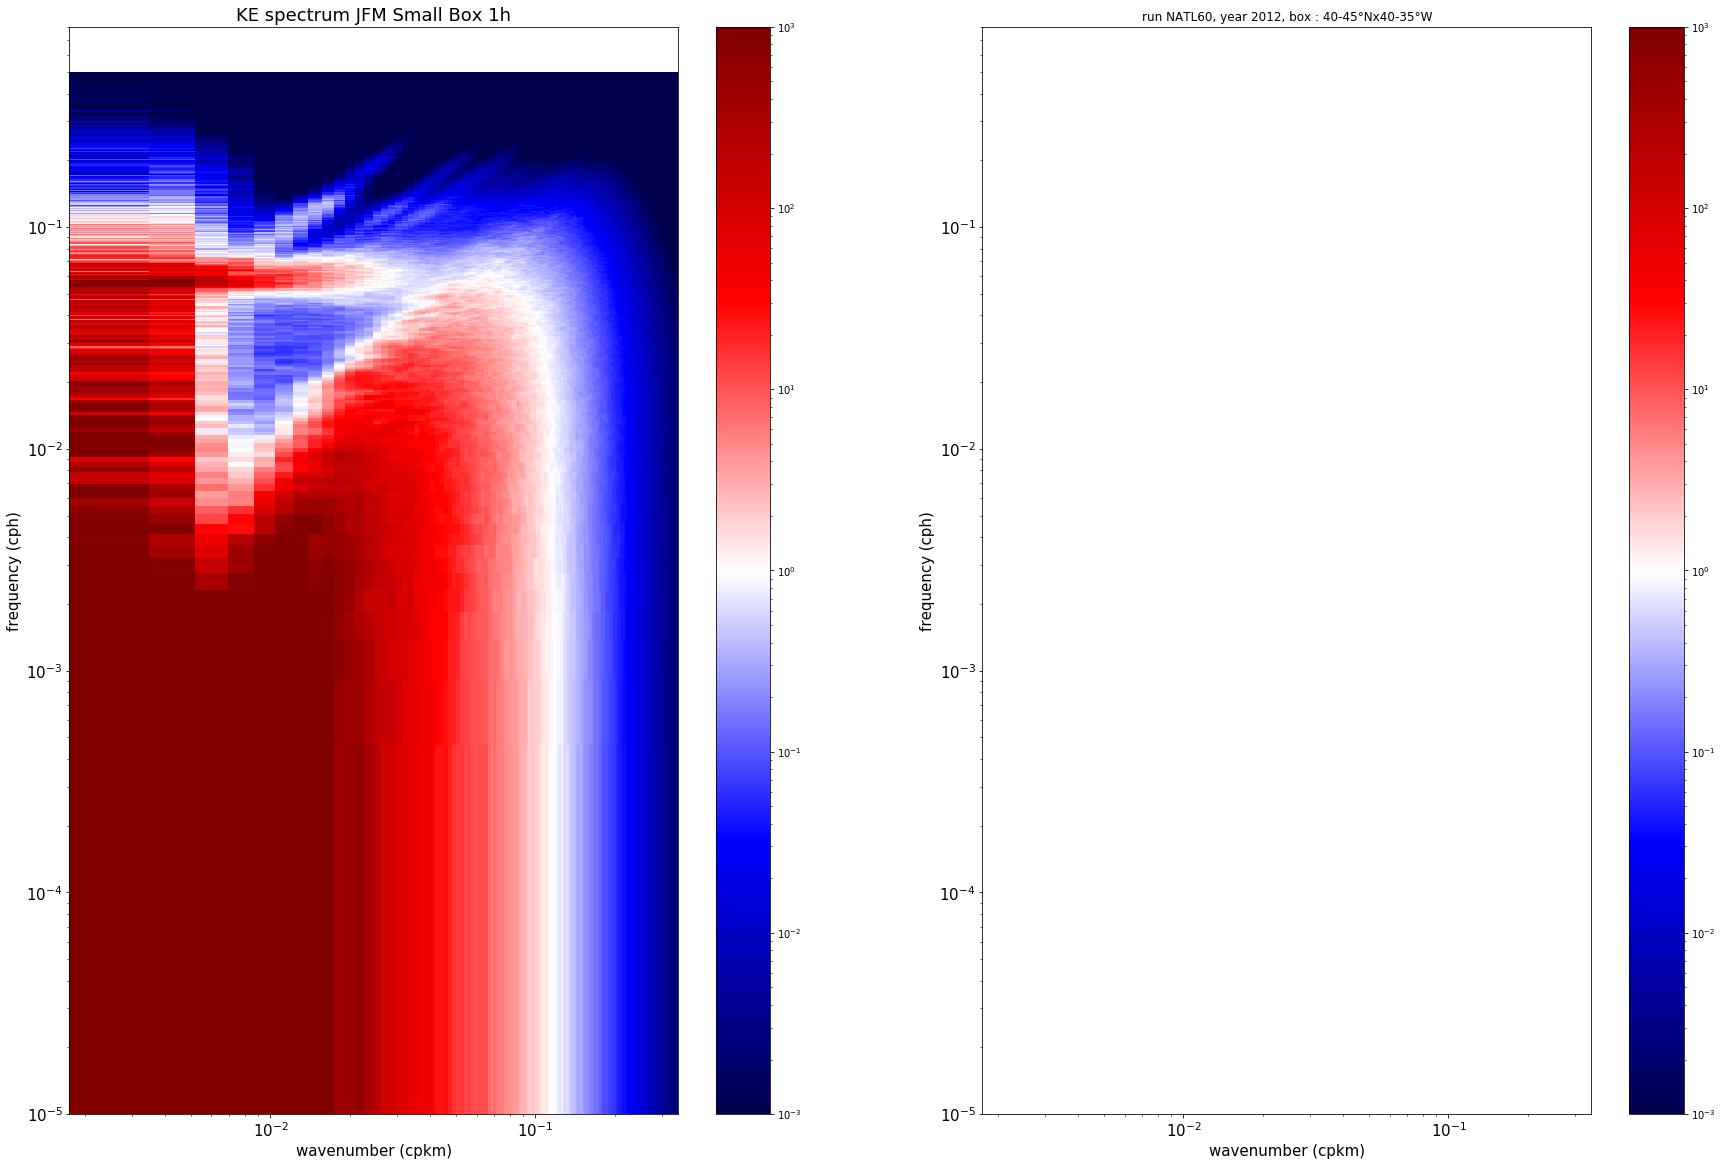

In [12]:
ds_JFM=xr.open_dataset('/mnt/alberta/equipes/IGE/meom/workdir/albert/NATL60/NATL60-CJM165-S/1h/KE_Spectrum_JFM_w_k_from_1h_NATL60-CJM165.nc')
ds_JAS=xr.open_dataset('/mnt/alberta/equipes/IGE/meom/workdir/albert/NATL60/NATL60-CJM165-S/1h/KE_Spectrum_JAS_w_k_from_1h_NATL60-CJM165.nc')

wavenumber_JFM=ds_JFM['wavenumber']
frequency_JFM=ds_JFM['frequency']
KE_JFM_wavenum_freq_spectrum=ds_JFM['Ke_spectrum']

wavenumber_JAS=ds_JAS['wavenumber']
frequency_JAS=ds_JAS['frequency']
KE_JAS_wavenum_freq_spectrum=ds_JAS['Ke_spectrum']


sec_to_hour = 3600.0
norm = LogNorm(vmin=0.001,vmax=1000)
cmap = div_cmap

fig=plt.figure(figsize=(30,20))

ax = plt.subplot(121)
plt.pcolormesh(wavenumber_JFM,sec_to_hour*frequency_JFM,KE_JFM_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(wavenumber_JFM.min(),wavenumber_JFM.max())
ax.set_ylim(1E-5,8E-1)
ax.set_title('KE spectrum JFM Small Box 1h',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()

ax = plt.subplot(122)
plt.pcolormesh(wavenumber_JAS,sec_to_hour*frequency_JAS,KE_JAS_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(wavenumber_JAS.min(),wavenumber_JAS.max())
ax.set_ylim(1E-5,8E-1)
ax.set_title('KE spectrum JAS Small Box 1h',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()

plt.title('run NATL60, year 2012, box : 40-45°Nx40-35°W')
plt.savefig('KE_spectrum_llc4320_JFM-JAS_smallbox.png')